Initializing NUTS using jitter+adapt_diag...



--- Running Model: weak ---


Sequential sampling (2 chains in 1 job)
NUTS: [m, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...



--- Running Model: strong ---


Sequential sampling (2 chains in 1 job)
NUTS: [m, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



--- HDI 95% (Weak Prior) ---
Media reala (m): [56.59, 59.55]
Deviatia reala (sigma): [1.30, 3.59]

--- Comparative Estimates ---
Method               Mean (mu)       Std (sigma)    
----------------------------------------------------
Frequentist          58.00           2.00           
Bayesian (Weak)      58.00           2.32           
Bayesian (Strong)    51.39           7.56           

Differences (Weak vs Frequentist):
mu: 0.0047
sigma: 0.3172


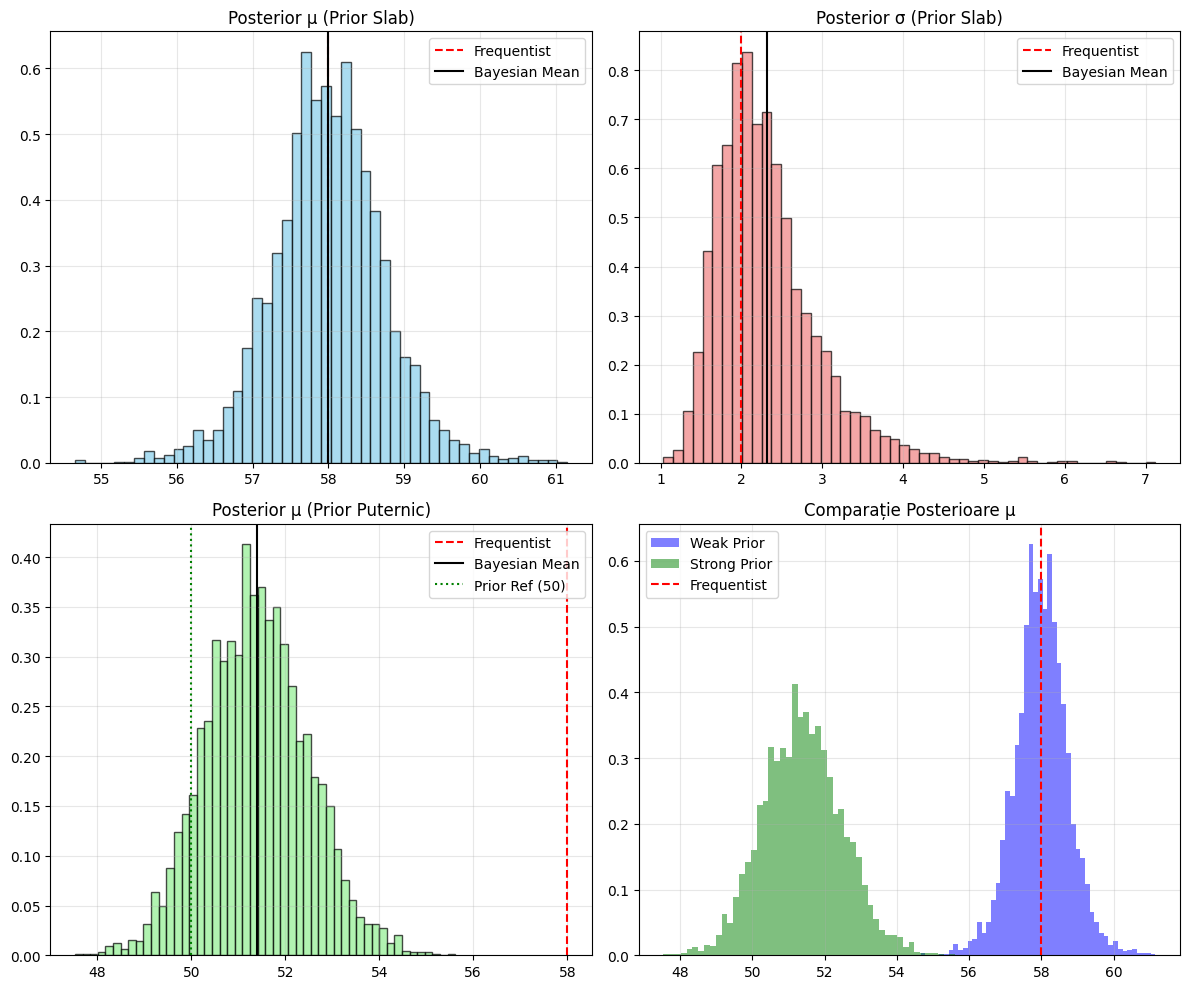

In [4]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

class BayesianAnalysisWorkflow:
    def __init__(self):
        # Constants and Data
        self.data = np.array([56, 60, 58, 55, 57, 59, 61, 56, 58, 60])
        self.mu_freq = np.mean(self.data)
        self.std_freq = np.std(self.data, ddof=1)
        
        self.seed = 74
        self.draws = 2000
        self.tune = 1000
        
        # Results storage
        self.results = {}

    def _build_and_sample(self, mu_prior_val, mu_prior_sigma, model_name):
        """Helper to construct and run PyMC models."""
        print(f"\n--- Running Model: {model_name} ---")
        with pm.Model() as model:
            # Priors
            m = pm.Normal('m', mu=mu_prior_val, sigma=mu_prior_sigma)
            sigma = pm.HalfNormal('sigma', sigma=10)
            
            # Likelihood
            pm.Normal('y', mu=m, sigma=sigma, observed=self.data)
            
            # Sampling
            trace = pm.sample(
                draws=self.draws, 
                tune=self.tune, 
                return_inferencedata=True, 
                random_seed=self.seed, 
                cores=1
            )
            self.results[model_name] = trace
        return trace

    def run_analysis(self):
        # 1. Run Weak Prior Model (Informativ based on mean)
        self._build_and_sample(self.mu_freq, 10, 'weak')
        
        # 2. Run Strong Prior Model
        self._build_and_sample(50, 1, 'strong')

    def display_summaries(self):
        weak_summary = az.summary(self.results['weak'], hdi_prob=0.95)
        
        print("\n--- HDI 95% (Weak Prior) ---")
        m_hdi = [weak_summary.loc['m', 'hdi_2.5%'], weak_summary.loc['m', 'hdi_97.5%']]
        s_hdi = [weak_summary.loc['sigma', 'hdi_2.5%'], weak_summary.loc['sigma', 'hdi_97.5%']]
        
        print(f"Media reala (m): [{m_hdi[0]:.2f}, {m_hdi[1]:.2f}]")
        print(f"Deviatia reala (sigma): [{s_hdi[0]:.2f}, {s_hdi[1]:.2f}]")

        # Comparison Logic
        m_weak = self.results['weak'].posterior['m'].mean().values
        s_weak = self.results['weak'].posterior['sigma'].mean().values
        m_strong = self.results['strong'].posterior['m'].mean().values
        s_strong = self.results['strong'].posterior['sigma'].mean().values

        print("\n--- Comparative Estimates ---")
        header = f"{'Method':<20} {'Mean (mu)':<15} {'Std (sigma)':<15}"
        print(header)
        print("-" * len(header))
        print(f"{'Frequentist':<20} {self.mu_freq:<15.2f} {self.std_freq:<15.2f}")
        print(f"{'Bayesian (Weak)':<20} {m_weak:<15.2f} {s_weak:<15.2f}")
        print(f"{'Bayesian (Strong)':<20} {m_strong:<15.2f} {s_strong:<15.2f}")
        
        print(f"\nDifferences (Weak vs Frequentist):")
        print(f"mu: {abs(m_weak - self.mu_freq):.4f}")
        print(f"sigma: {abs(s_weak - self.std_freq):.4f}")

    def generate_visuals(self):
        # 
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Extract posterior samples
        post_w = self.results['weak'].posterior
        post_s = self.results['strong'].posterior

        # Helper for plotting histograms
        def plot_hist(ax, data, title, color, freq_val, label_prefix, prior_ref=None):
            ax.hist(data.flatten(), bins=50, density=True, alpha=0.7, color=color, edgecolor='black')
            ax.axvline(freq_val, color='red', linestyle='--', label='Frequentist')
            ax.axvline(np.mean(data), color='black', linestyle='-', label=f'{label_prefix} Mean')
            if prior_ref:
                ax.axvline(prior_ref, color='green', linestyle=':', label=f'Prior Ref ({prior_ref})')
            ax.set_title(title)
            ax.legend()
            ax.grid(alpha=0.3)

        # Fill the grid
        plot_hist(axes[0,0], post_w['m'].values, 'Posterior μ (Prior Slab)', 'skyblue', self.mu_freq, 'Bayesian')
        plot_hist(axes[0,1], post_w['sigma'].values, 'Posterior σ (Prior Slab)', 'lightcoral', self.std_freq, 'Bayesian')
        plot_hist(axes[1,0], post_s['m'].values, 'Posterior μ (Prior Puternic)', 'lightgreen', self.mu_freq, 'Bayesian', 50)

        # Plot 4: Comparison
        axes[1,1].hist(post_w['m'].values.flatten(), bins=50, alpha=0.5, label='Weak Prior', density=True, color='blue')
        axes[1,1].hist(post_s['m'].values.flatten(), bins=50, alpha=0.5, label='Strong Prior', density=True, color='green')
        axes[1,1].axvline(self.mu_freq, color='red', linestyle='--', label='Frequentist')
        axes[1,1].set_title('Comparație Posterioare μ')
        axes[1,1].legend()
        axes[1,1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('outputs/bayesian_inference.png', dpi=150)
        plt.show()

if __name__ == '__main__':
    analysis = BayesianAnalysisWorkflow()
    analysis.run_analysis()
    analysis.display_summaries()
    analysis.generate_visuals()